In [1]:
import xarray as xr
import matplotlib.pylab as plt
import Rbeast as rb
import numpy as np
import cartopy.crs as ccrss
import cartopy.feature as cf
import matplotlib as mpl
import pandas as pd
import my_funs
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import BallTree, DistanceMetric
from causalimpact import CausalImpact
import pickle
from sklearn.impute import IterativeImputer
from dask.diagnostics import ProgressBar
from tqdm import tqdm
from scipy import stats

mpl.rcParams["mathtext.default"] = "regular"
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from my_funs import outliers_index

Initialization done!


/data/home/hamiddashti/hamid/nasa_above/greeness/codes/src/my_funs.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
2023-08-07 12:38:29.632821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follo

In [2]:
dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/"
t=pd.date_range(start="1984",end="2012",freq="A-Dec").year
fnames = []
for i in np.arange(1984,2012):
    fnames.append(dir+"mosaic_NDVI_"+str(i)+"_TM5.tif")
ndvi_tm = xr.open_mfdataset(fnames,concat_dim="time",combine="nested",parallel=True,chunks={"y":2000,"x":2000}).squeeze()["band_data"]
ndvi_tm["time"] = t
ndvi_tm

<xarray.DataArray 'band_data' (time: 28, y: 108000, x: 102000)>
dask.array<getitem, shape=(28, 108000, 102000), dtype=float32, chunksize=(1, 2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 -3.22e+06 -3.22e+06 ... -1.601e+05 -1.6e+05
  * y            (y) float64 4.64e+06 4.64e+06 4.64e+06 ... 1.4e+06 1.4e+06
    spatial_ref  int64 0
  * time         (time) int64 1984 1985 1986 1987 1988 ... 2008 2009 2010 2011
Attributes:
    AREA_OR_POINT:  Area

In [3]:
dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/"
t=pd.date_range(start="1999",end="2015",freq="A-Dec").year
fnames = []
for i in np.arange(1999,2015):
    fnames.append(dir+"mosaic_NDVI_"+str(i)+"_ETM.tif")
ndvi_etm = xr.open_mfdataset(fnames,concat_dim="time",combine="nested",parallel=True,chunks={"y":2000,"x":2000}).squeeze()["band_data"]
ndvi_etm["time"] = t
ndvi_etm

<xarray.DataArray 'band_data' (time: 16, y: 108000, x: 102000)>
dask.array<getitem, shape=(16, 108000, 102000), dtype=float32, chunksize=(1, 2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 -3.22e+06 -3.22e+06 ... -1.601e+05 -1.6e+05
  * y            (y) float64 4.64e+06 4.64e+06 4.64e+06 ... 1.4e+06 1.4e+06
    spatial_ref  int64 0
  * time         (time) int64 1999 2000 2001 2002 2003 ... 2011 2012 2013 2014
Attributes:
    AREA_OR_POINT:  Area

In [4]:
dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/data/raw_data/landcover/mosaic/"
t=pd.date_range(start="1984",end="2015",freq="A-Dec").year
fnames = []
for i in np.arange(1984,2015):
    fnames.append(dir+"mosaic_"+str(i)+".tif")
lc = xr.open_mfdataset(fnames,concat_dim="time",combine="nested",parallel=True,chunks={"y":2000,"x":2000}).squeeze()["band_data"]
lc["time"] = t
lc_tm = lc.sel(time=slice("1984","2012"))
lc_tm

<xarray.DataArray 'band_data' (time: 29, y: 108000, x: 102000)>
dask.array<getitem, shape=(29, 108000, 102000), dtype=float32, chunksize=(1, 2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 -3.22e+06 -3.22e+06 ... -1.601e+05 -1.6e+05
  * y            (y) float64 4.64e+06 4.64e+06 4.64e+06 ... 1.4e+06 1.4e+06
    spatial_ref  int64 0
  * time         (time) int64 1984 1985 1986 1987 1988 ... 2009 2010 2011 2012
Attributes:
    AREA_OR_POINT:  Area

In [36]:
ndvi_tm_test = ndvi_tm.sel(time=slice("2005","2009")).isel(y=np.arange(54000,54100),x =np.arange(51000,51100))
ndvi_etm_test = ndvi_etm.sel(time=slice("2005","2009")).isel(y=np.arange(54000,54100),x =np.arange(51000,51100))
lc_test = lc_tm.isel(y=np.arange(54000,54100),x =np.arange(51000,51100))

In [90]:
ndvi_tm_test[:,0,1].values

array([6541., 7625., 7983., 7561., 7283.], dtype=float32)

In [89]:
ndvi_etm_test[:,0,1].values

array([8324., 9250., 9237.,   nan,   nan], dtype=float32)

In [ ]:
ndvi_tm_test.to_netcdf(ndvi_tm_test)
ndvi_etm_test.to_netcdf("../../")

In [28]:
not_changed = (lc_test.diff("time")==0).all("time")

In [82]:
ef = (lc_test==1).all("time")
tm_ef = ndvi_tm_test.where(ef==True).stack(dim=["time","y","x"])
etm_ef = ndvi_etm_test.where(ef==True).stack(dim=["time","y","x"])
df = pd.DataFrame([tm_ef.values,etm_ef.values],index=["TM","ETM"]).transpose()
df = df.dropna()
df_clean = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df_clean

,TM,ETM
0,6204.0,8324.0
1,6541.0,8324.0
2,6896.0,8662.0
3,7215.0,8324.0
4,7418.0,8394.0
...,...,...
49975,7362.0,7211.0
49976,6421.0,7374.0
49977,6357.0,5971.0
49998,6917.0,7698.0


<AxesSubplot:xlabel='TM', ylabel='ETM'>

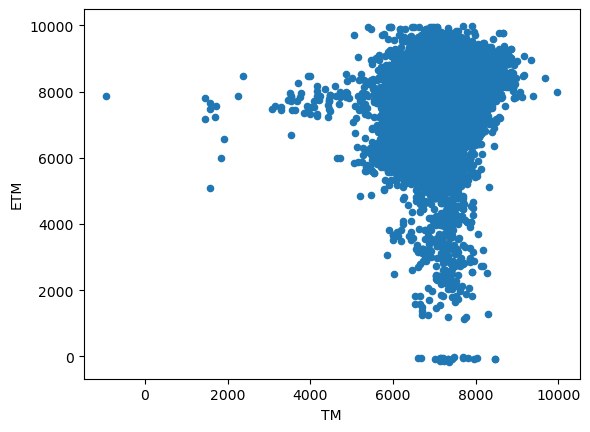

In [80]:
df.plot.scatter(x="TM",y="ETM")

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
x = df["TM"].values.reshape(-1, 1)
y=df["ETM"].values.reshape(-1, 1)

mdl = LinearRegression().fit(x, y)
Y_pred = mdl.predict(x) 
mdl.score(x, y)

0.05242603333409235

0.038461197935928504

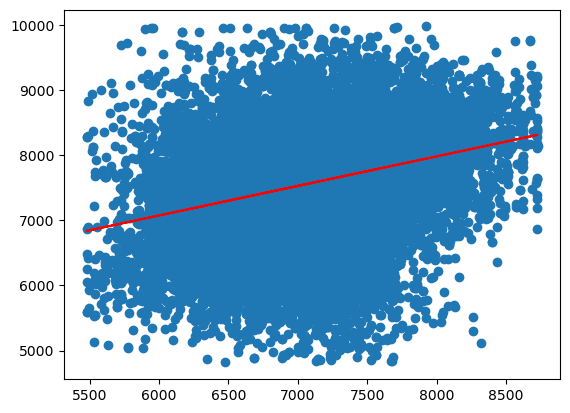

In [51]:
plt.scatter(x,y)
plt.plot(x, Y_pred, color='red')

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ndvi_tm.isel(time=3,y=np.arange(54000,54100),x =np.arange(51000,51100)).plot()

In [ ]:
df = pd.DataFrame([ndvi_tm_test.values,ndvi_etm_test.values],index=["TM","ETM"]).transpose()
df = df.dropna()
df

In [ ]:
df.plot.scatter(x="TM",y="ETM")

In [ ]:
# import dask
# from multiprocessing.pool import ThreadPool 
# with dask.config.set(schedular='threads', pool=ThreadPool(5)):
#     lc_tm.isel(time=3,y=np.arange(54000,56100),x =np.arange(51000,52100)).plot()